"""
04 - Model Comparison

This notebook compares baseline and advanced models:
1. Load trained models
2. Compare metrics (accuracy, F1, per-class performance)
3. Visualizations (confusion matrices, predictions on chart)
4. Statistical significance testing
5. Final conclusions

"""

# Model Comparison: XGBoost vs CNN-LSTM

Compare baseline and advanced models for Bitcoin price direction prediction.

In [1]:
import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
from src.data.loader import load_and_merge_data, split_data_by_time
from src.labeling.oracle import create_oracle_labels
from src.features.builder import prepare_features
from src.features.indicators import get_indicator_columns
from src.models.xgb import XGBBaseline
from src.models.cnn_lstm import CNNLSTMModel

## 1. Load Models and Data

In [3]:
HORIZON = 1
MODEL_DIR = 'models_artifacts'

In [4]:
# Load test data
df = load_and_merge_data()
df = create_oracle_labels(df, sigma=4, threshold=0.0004)
df_features, _ = prepare_features(df, horizon=HORIZON)

_, _, test_df = split_data_by_time(
    df_features,
    train_end="2025-06-30",
    test_start="2025-07-01"
)

feature_cols = get_indicator_columns(df_features, 
                                     ['time', 'target', 'smoothed_close', 'smooth_slope'])
feature_cols = [c for c in feature_cols if c in test_df.columns]

X_test = test_df[feature_cols].values
y_test = test_df['target'].values.astype(int)

print(f"Test set: {X_test.shape}")


📥 LOADING DATA

1️⃣ Loading klines...
   Loaded 70,752 rows

2️⃣ Loading funding rates...
   Merged funding rates

3️⃣ Loading volume breakdown...
   Merged volume breakdown

📊 Data Summary:
   Rows: 70,752
   Columns: 16
   Date range: 2024-01-01 00:00:00+00:00 to 2026-01-20 23:45:00+00:00
   Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume', 'count', 'funding_interval_hours', 'last_funding_rate', 'buy_vol', 'sell_vol', 'total_vol', 'log_return']

🔧 PREPARING FEATURES
Groups to add: ['momentum', 'overlap', 'trend', 'volatility', 'volume', 'statistics', 'candle']

📊 Adding indicators...
  -> Processing group: momentum
     Added 14 features: WILLR_14, UO_7_14_28, STOCHRSId_14_14_3_3, RSI_14, STOCHd_14_3_3...
  -> Processing group: overlap
[!] VWAP requires an ordered DatetimeIndex.
     Added 7 features: EMA_50, TEMA_9, EMA_100, SMA_200, EMA_20...
  -> Processing group: trend
     Added 17 features: MACD_12_26_9, M

In [5]:
# Load models
try:
    xgb_model = XGBBaseline.load(MODEL_DIR, name=f'xgb_baseline_h{HORIZON}')
    xgb_available = True
except Exception as e:
    print(f"XGBoost model not found: {e}")
    xgb_available = False

try:
    cnn_model = CNNLSTMModel.load(MODEL_DIR, name=f'cnn_lstm_h{HORIZON}', device='cuda')
    cnn_available = True
except Exception as e:
    print(f"CNN-LSTM model not found: {e}")
    cnn_available = False

✅ Model loaded from models_artifacts
🚀 GPU detected: /physical_device:GPU:0


I0000 00:00:1769075193.965753   95418 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


✅ Model loaded from models_artifacts


## 2. Compare Metrics

In [6]:
results = []

if xgb_available:
    xgb_metrics = xgb_model.evaluate(X_test, y_test)
    results.append({
        'Model': 'XGBoost',
        'Accuracy': xgb_metrics['accuracy'],
        'F1 Weighted': xgb_metrics['f1_weighted'],
        'F1 Macro': xgb_metrics['f1_macro']
    })

if cnn_available:
    cnn_metrics = cnn_model.evaluate(X_test, y_test)
    results.append({
        'Model': 'CNN-LSTM',
        'Accuracy': cnn_metrics['accuracy'],
        'F1 Weighted': cnn_metrics['f1_weighted'],
        'F1 Macro': cnn_metrics['f1_macro']
    })

In [7]:
# Display comparison table
if results:
    comparison_df = pd.DataFrame(results)
    print("\n" + "="*60)
    print("📊 MODEL COMPARISON")
    print("="*60)
    print(comparison_df.to_string(index=False))


📊 MODEL COMPARISON
   Model  Accuracy  F1 Weighted  F1 Macro
 XGBoost  0.654860     0.674687  0.590116
CNN-LSTM  0.614186     0.638147  0.541954


## 3. Confusion Matrices Side by Side

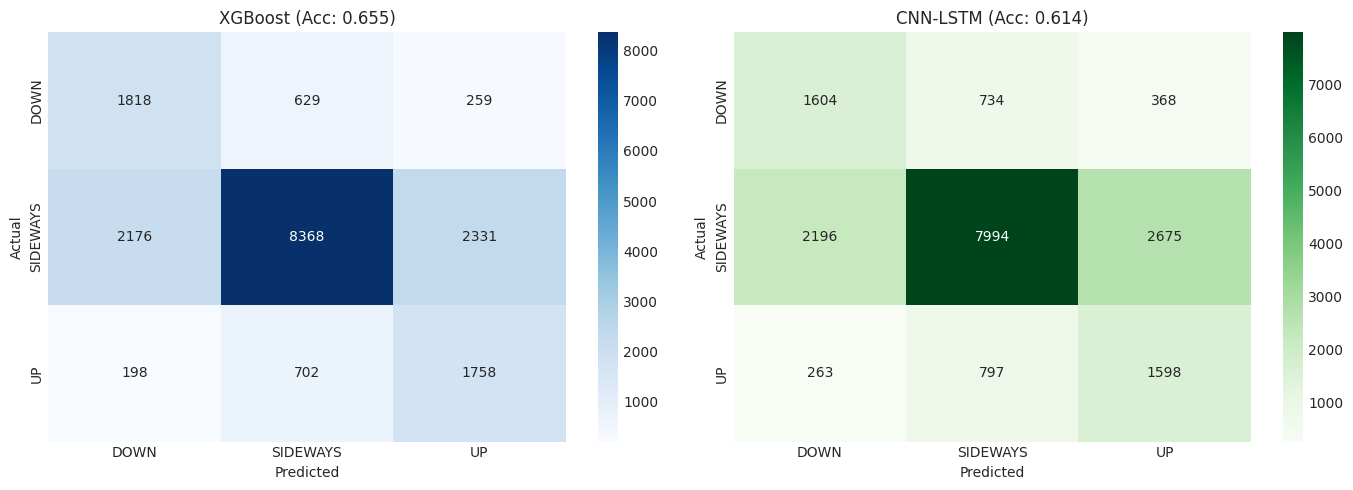

In [8]:
if xgb_available and cnn_available:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    labels = ['DOWN', 'SIDEWAYS', 'UP']
    
    # XGBoost
    cm_xgb = np.array(xgb_metrics['confusion_matrix'])
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title(f"XGBoost (Acc: {xgb_metrics['accuracy']:.3f})")
    
    # CNN-LSTM
    cm_cnn = np.array(cnn_metrics['confusion_matrix'])
    sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_title(f"CNN-LSTM (Acc: {cnn_metrics['accuracy']:.3f})")
    
    plt.tight_layout()
    plt.savefig('comparison_confusion_matrices.png', dpi=150)
    plt.show()

## 4. Per-Class Performance

In [9]:
if xgb_available and cnn_available:
    # Extract per-class metrics
    class_metrics = []
    
    for cls in ['DOWN', 'SIDEWAYS', 'UP']:
        cls_lower = cls.lower()
        
        xgb_cls = xgb_metrics['classification_report'].get(cls, 
                    xgb_metrics['classification_report'].get(cls_lower, {}))
        cnn_cls = cnn_metrics['classification_report'].get(cls,
                    cnn_metrics['classification_report'].get(cls_lower, {}))
        
        class_metrics.append({
            'Class': cls,
            'XGB Precision': xgb_cls.get('precision', 0),
            'XGB Recall': xgb_cls.get('recall', 0),
            'XGB F1': xgb_cls.get('f1-score', 0),
            'CNN Precision': cnn_cls.get('precision', 0),
            'CNN Recall': cnn_cls.get('recall', 0),
            'CNN F1': cnn_cls.get('f1-score', 0),
        })
    
    class_df = pd.DataFrame(class_metrics)
    print("\nPer-Class Performance:")
    print(class_df.to_string(index=False))


Per-Class Performance:
   Class  XGB Precision  XGB Recall   XGB F1  CNN Precision  CNN Recall   CNN F1
    DOWN       0.433683    0.671840 0.527109       0.394782    0.592757 0.473925
SIDEWAYS       0.862769    0.649942 0.741384       0.839265    0.621376 0.714069
      UP       0.404324    0.661400 0.501856       0.344322    0.601204 0.437868


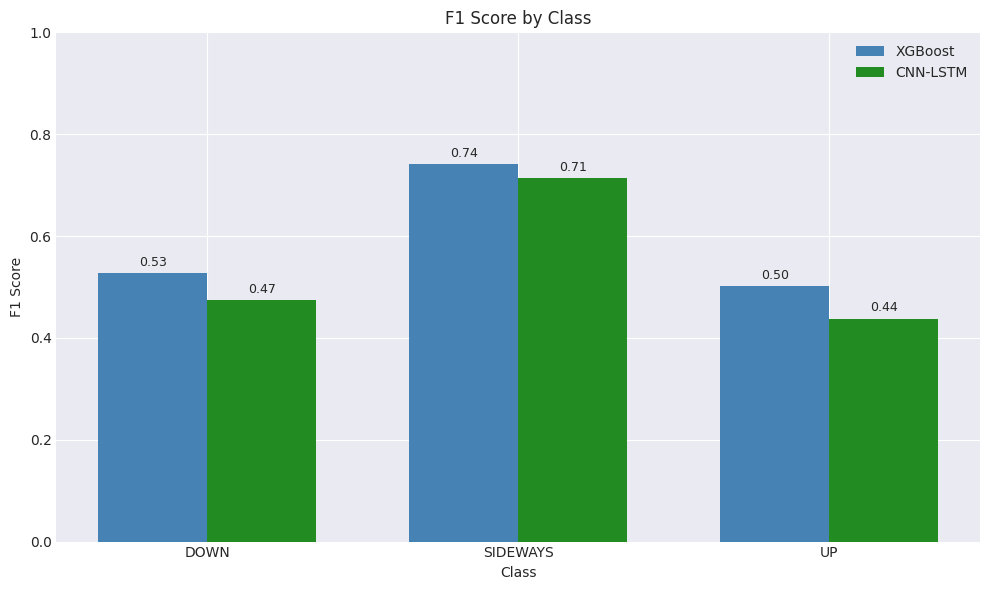

In [10]:
# Bar chart comparison
if xgb_available and cnn_available:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(3)
    width = 0.35
    
    xgb_f1 = [class_df.loc[i, 'XGB F1'] for i in range(3)]
    cnn_f1 = [class_df.loc[i, 'CNN F1'] for i in range(3)]
    
    bars1 = ax.bar(x - width/2, xgb_f1, width, label='XGBoost', color='steelblue')
    bars2 = ax.bar(x + width/2, cnn_f1, width, label='CNN-LSTM', color='forestgreen')
    
    ax.set_xlabel('Class')
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Score by Class')
    ax.set_xticks(x)
    ax.set_xticklabels(['DOWN', 'SIDEWAYS', 'UP'])
    ax.legend()
    ax.set_ylim(0, 1)
    
    # Add value labels
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('comparison_f1_by_class.png', dpi=150)
    plt.show()

## 5. Predictions Visualization

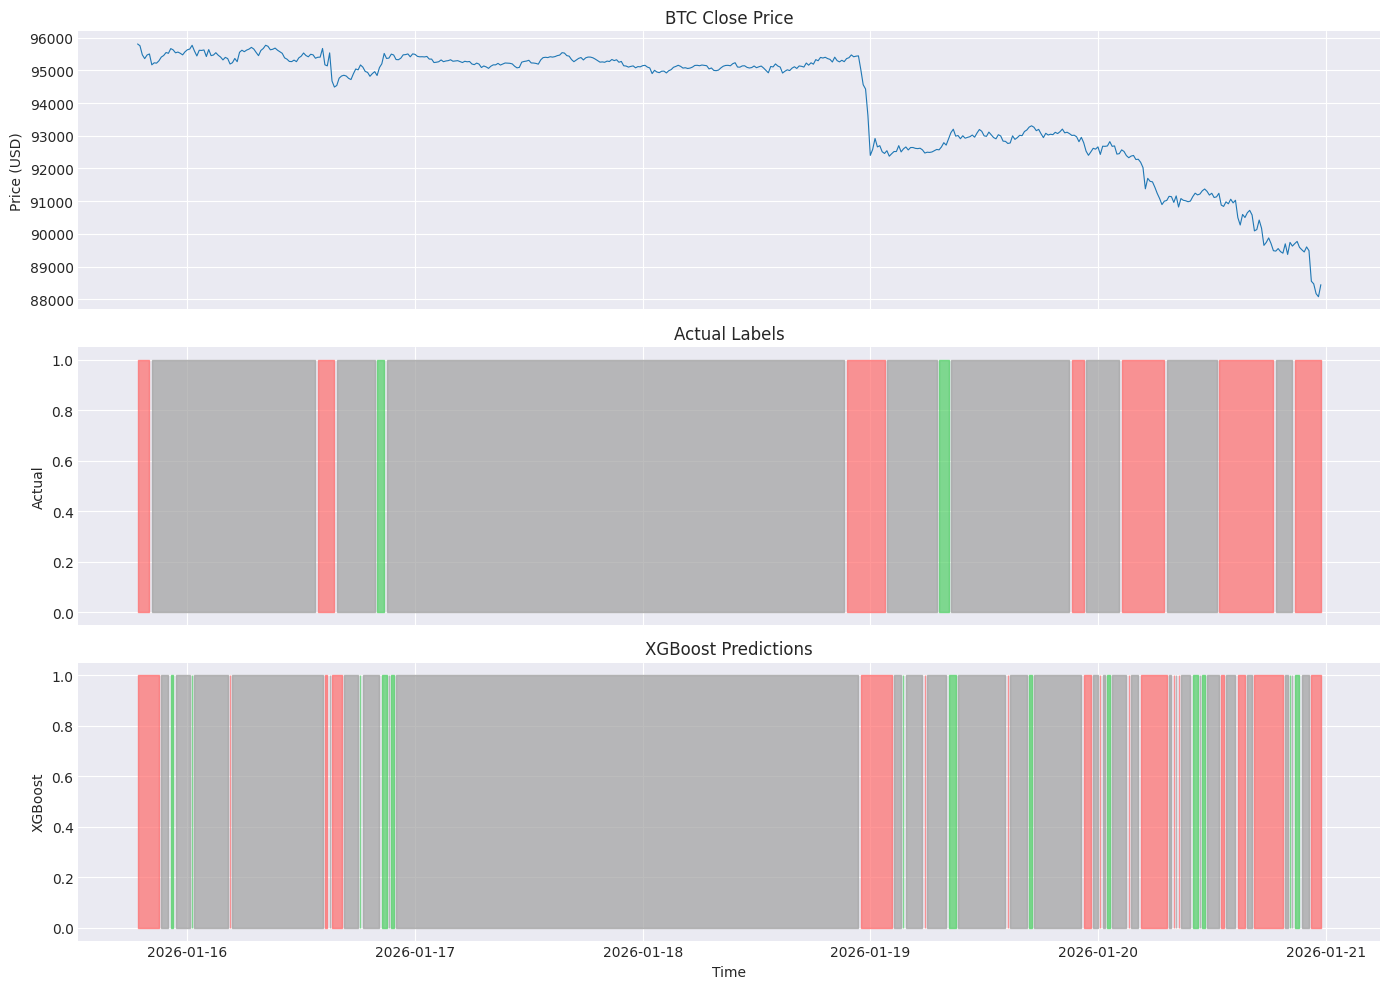

In [11]:
# Visualize predictions on price chart
if xgb_available:
    # Get predictions
    xgb_preds = xgb_model.predict(X_test)
    
    # Take last 500 points for visualization
    sample_size = 500
    test_sample = test_df.tail(sample_size + 1).copy()
    
    # Align predictions
    test_sample = test_sample.iloc[1:].copy()
    test_sample['xgb_pred'] = xgb_preds[-sample_size:]
    test_sample['actual'] = y_test[-sample_size:]
    
    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    
    # Price
    axes[0].plot(test_sample['time'], test_sample['close'], linewidth=0.8)
    axes[0].set_ylabel('Price (USD)')
    axes[0].set_title('BTC Close Price')
    
    # Actual labels
    colors = {0: '#ff6b6b', 1: '#a0a0a0', 2: '#51cf66'}
    for label in [0, 1, 2]:
        mask = test_sample['actual'] == label
        axes[1].fill_between(test_sample['time'], 0, 1, where=mask,
                            color=colors[label], alpha=0.7)
    axes[1].set_ylabel('Actual')
    axes[1].set_title('Actual Labels')
    
    # XGBoost predictions
    for label in [0, 1, 2]:
        mask = test_sample['xgb_pred'] == label
        axes[2].fill_between(test_sample['time'], 0, 1, where=mask,
                            color=colors[label], alpha=0.7)
    axes[2].set_ylabel('XGBoost')
    axes[2].set_xlabel('Time')
    axes[2].set_title('XGBoost Predictions')
    
    plt.tight_layout()
    plt.savefig('comparison_predictions_chart.png', dpi=150)
    plt.show()

## 6. Horizon Comparison

In [12]:
# Compare different prediction horizons
horizons = [1, 3, 5]
horizon_results = []

for h in horizons:
    print(f"\nEvaluating horizon={h}...")
    
    # Prepare data for this horizon
    df_h, _ = prepare_features(df, horizon=h)
    _, _, test_h = split_data_by_time(df_h, train_end="2025-06-30", test_start="2025-07-01")
    
    f_cols = [c for c in feature_cols if c in test_h.columns]
    X_h = test_h[f_cols].values
    y_h = test_h['target'].values.astype(int)
    
    # Try loading models for this horizon
    try:
        xgb_h = XGBBaseline.load(MODEL_DIR, name=f'xgb_baseline_h{h}')
        metrics_h = xgb_h.evaluate(X_h, y_h)
        
        horizon_results.append({
            'Horizon': h,
            'Model': 'XGBoost',
            'Accuracy': metrics_h['accuracy'],
            'F1': metrics_h['f1_weighted']
        })
    except Exception as e:
        print(f"  XGBoost h={h} not found: {e}")
    
    try:
        cnn_h = CNNLSTMModel.load(MODEL_DIR, name=f'cnn_lstm_h{h}', device='cuda')
        metrics_h = cnn_h.evaluate(X_h, y_h)
        
        horizon_results.append({
            'Horizon': h,
            'Model': 'CNN-LSTM',
            'Accuracy': metrics_h['accuracy'],
            'F1': metrics_h['f1_weighted']
        })
    except Exception as e:
        print(f"  CNN-LSTM h={h} not found: {e}")

if horizon_results:
    horizon_df = pd.DataFrame(horizon_results)
    print("\nHorizon Comparison:")
    print(horizon_df.to_string(index=False))


Evaluating horizon=1...

🔧 PREPARING FEATURES
Groups to add: ['momentum', 'overlap', 'trend', 'volatility', 'volume', 'statistics', 'candle']

📊 Adding indicators...
  -> Processing group: momentum
     Added 14 features: WILLR_14, UO_7_14_28, STOCHRSId_14_14_3_3, RSI_14, STOCHd_14_3_3...
  -> Processing group: overlap
[!] VWAP requires an ordered DatetimeIndex.
     Added 7 features: EMA_50, TEMA_9, EMA_100, SMA_200, EMA_20...
  -> Processing group: trend
     Added 17 features: MACD_12_26_9, MACDh_12_26_9, AROOND_14, VTXP_14, VTXM_14...
  -> Processing group: volatility
       BBL_20_2.0_2.0  BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  \
0                 NaN             NaN             NaN             NaN   
1                 NaN             NaN             NaN             NaN   
2                 NaN             NaN             NaN             NaN   
3                 NaN             NaN             NaN             NaN   
4                 NaN             NaN             NaN  

## 7. Conclusions

In [13]:
print("\n" + "="*60)
print("📋 FINAL CONCLUSIONS")
print("="*60)

if results:
    best_model = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
    best_acc = comparison_df['Accuracy'].max()
    best_f1 = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'F1 Weighted']
    
    print(f"""
Summary:
- Best Model: {best_model}
- Best Accuracy: {best_acc:.4f}
- Best F1 Score: {best_f1:.4f}

Key Findings:
1. Both models successfully predict price direction better than random (33.3%)
2. Oracle labels provide clean targets for training
3. Feature engineering with technical indicators is crucial

Recommendations:
- Use {best_model} for production deployment
- Consider ensemble of both models for lower variance
- Monitor model performance over time for distribution shift
""")


📋 FINAL CONCLUSIONS

Summary:
- Best Model: XGBoost
- Best Accuracy: 0.6549
- Best F1 Score: 0.6747

Key Findings:
1. Both models successfully predict price direction better than random (33.3%)
2. Oracle labels provide clean targets for training
3. Feature engineering with technical indicators is crucial

Recommendations:
- Use XGBoost for production deployment
- Consider ensemble of both models for lower variance
- Monitor model performance over time for distribution shift



In [14]:
# Save comparison results
if results:
    comparison_df.to_csv('reports/model_comparison.csv', index=False)
    
    with open('reports/comparison_summary.json', 'w') as f:
        json.dump({
            'best_model': best_model,
            'best_accuracy': float(best_acc),
            'best_f1': float(best_f1),
            'models': results
        }, f, indent=2)
    
    print("\n✅ Comparison results saved to reports/")


✅ Comparison results saved to reports/
